# USAD

## Environment

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

from utils import *
from usad import *

In [99]:
!nvidia-smi -L

device = get_default_device()

GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-1e84eb32-9819-cc34-0b25-e159dc3f19e9)


## EDA - Data Pre-Processing

### Download dataset

In [110]:
dataset = pd.read_csv("data/MQTT_station1.csv", nrows=20000)
dataset['label'] = 0
normal, attack = train_test_split(dataset, test_size=0.5, shuffle=False)

### Normal period

In [111]:
normal.head(5)

,Time,Message_Length,GPR_Topic,Area_Topic,VAR_Topic_1,VAR_Topic_2,Message_ID,Message_Value,Message_q,Message_Time,label
0,2023-09-05 16:39:46.584310,79,N143,T1,400,Ia,MF7,30.3,True,2023-09-05 16:39:46,0
1,2023-09-05 16:39:47.536947,83,N143,LV1,GRP5,Ib,MF43,-28.3,True,2023-09-05 16:39:47,0
2,2023-09-05 16:39:50.746603,78,N143,T1,400,Q,MF3,25.3,True,2023-09-05 16:39:50,0
3,2023-09-05 16:39:50.796822,78,N143,T1,400,S,MF4,28.2,True,2023-09-05 16:39:50,0
4,2023-09-05 16:39:50.847194,78,N143,T1,400,Q,MF3,26.4,True,2023-09-05 16:39:50,0


In [112]:
#Read data
#, nrows=1000)
normal = normal.drop(["Time" , "Message_Time" ] , axis = 1)
normal.shape

(10000, 9)

In [113]:
normal.head(5)

,Message_Length,GPR_Topic,Area_Topic,VAR_Topic_1,VAR_Topic_2,Message_ID,Message_Value,Message_q,label
0,79,N143,T1,400,Ia,MF7,30.3,True,0
1,83,N143,LV1,GRP5,Ib,MF43,-28.3,True,0
2,78,N143,T1,400,Q,MF3,25.3,True,0
3,78,N143,T1,400,S,MF4,28.2,True,0
4,78,N143,T1,400,Q,MF3,26.4,True,0


In [114]:
print(f'{normal.memory_usage(deep=True).sum()} bytes')
print(f'{normal.memory_usage(deep=True).sum() / 2**20} MB')

3381969 bytes
3.225296974182129 MB


In [115]:
# Transform all columns into float64
col = lambda column : [ord(char) for char in column]
for i in list(normal):
    normal[i]=normal[i].apply(lambda column: ''.join(map(str, col(str(column))))  if not str(column).replace(".", "").isdigit() else str(column).replace("," , "."))
normal = normal.astype(float)

In [116]:
print(f'{normal.memory_usage(deep=True).sum()} bytes')
print(f'{normal.memory_usage(deep=True).sum() / 2**20} MB')

800000 bytes
0.762939453125 MB


In [117]:
normal.head(5)

,Message_Length,GPR_Topic,Area_Topic,VAR_Topic_1,VAR_Topic_2,Message_ID,Message_Value,Message_q,label
0,79.0,78495251.0,8449.0,400.0,7397.0,777055.0,3.030000e+01,8.411412e+10,0.0
1,83.0,78495251.0,768649.0,71828053.0,7398.0,77705251.0,4.550565e+09,8.411412e+10,0.0
2,78.0,78495251.0,8449.0,400.0,81.0,777051.0,2.530000e+01,8.411412e+10,0.0
3,78.0,78495251.0,8449.0,400.0,83.0,777052.0,2.820000e+01,8.411412e+10,0.0
4,78.0,78495251.0,8449.0,400.0,81.0,777051.0,2.640000e+01,8.411412e+10,0.0


#### Normalization

In [118]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [109]:
normal.head(2)

,0,1,2,3,4,5,6,7
0,0.125000,0.0,0.000000,0.000005,8.635988e-09,8.321548e-26,3.586085e-87,0.0
1,0.208333,0.0,0.000001,1.000000,8.637168e-09,1.066936e-18,5.385713e-79,0.0


### Attack

In [119]:
#Read data
labels = attack['label'].values
attack = attack.drop(["Time" , "Message_Time"] , axis = 1)
attack.shape

(10000, 9)

In [120]:
# Transform all columns into float64
col = lambda column : [ord(char) for char in column]
for i in list(attack):
    attack[i]=attack[i].apply(lambda column: ''.join(map(str, col(str(column))))  if not str(column).replace(".", "").isdigit() else str(column).replace("," , "."))
attack = attack.astype(float)

#### Normalization

In [121]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [122]:
attack.head(2)

,0,1,2,3,4,5,6,7,8
0,0.125,0.0,0.0,0.000005,8.635988e-09,8.321548e-26,4.923469e-87,0.0,0.0
1,0.125,0.0,0.0,0.000005,0.000000e+00,1.386925e-26,5.384482e-79,0.0,0.0


### Windows

In [123]:
window_size=12

In [124]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(9988, 12, 9)

In [125]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(9988, 12, 9)

## Training

In [126]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [127]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.2325, val_loss2: 0.2329
Epoch [1], val_loss1: 0.2302, val_loss2: -0.0000
Epoch [2], val_loss1: 0.2273, val_loss2: -0.0759
Epoch [3], val_loss1: 0.2239, val_loss2: -0.1121
Epoch [4], val_loss1: 0.2199, val_loss2: -0.1322
Epoch [5], val_loss1: 0.2153, val_loss2: -0.1439
Epoch [6], val_loss1: 0.2099, val_loss2: -0.1505
Epoch [7], val_loss1: 0.2039, val_loss2: -0.1537
Epoch [8], val_loss1: 0.1971, val_loss2: -0.1544
Epoch [9], val_loss1: 0.1895, val_loss2: -0.1532
Epoch [10], val_loss1: 0.1811, val_loss2: -0.1503
Epoch [11], val_loss1: 0.1721, val_loss2: -0.1461
Epoch [12], val_loss1: 0.1626, val_loss2: -0.1407
Epoch [13], val_loss1: 0.1526, val_loss2: -0.1345
Epoch [14], val_loss1: 0.1425, val_loss2: -0.1275
Epoch [15], val_loss1: 0.1324, val_loss2: -0.1201
Epoch [16], val_loss1: 0.1226, val_loss2: -0.1124
Epoch [17], val_loss1: 0.1132, val_loss2: -0.1047
Epoch [18], val_loss1: 0.1043, val_loss2: -0.0971
Epoch [19], val_loss1: 0.0960, val_loss2: -0.0896
Epoch [20],

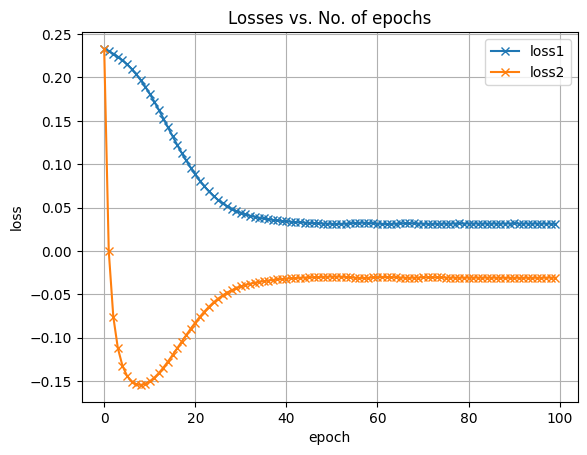

In [128]:
plot_history(history)

In [129]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [130]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [131]:
results=testing(model,test_loader)

In [132]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [133]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [134]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [138]:
y_pred[:5]

array([0.02830483, 0.02908452, 0.03105126, 0.03418433, 0.03396217],
      dtype=float32)

In [139]:
y_test[:5]

[0, 0, 0, 0, 0]

In [135]:
threshold=ROC(y_test,y_pred)

d:\Github\usad\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.